In [ ]:
# pull training data and link it to analysis-ready data
# todo: either access locally or use Window to access on S3 (might need to use bbox instead though)

In [16]:
import os

try:
    from common.sagemaker_env import LABELBOX_API_KEY
except: 
    LABELBOX_API_KEY = os.environ['LABELBOX_API_KEY']

In [4]:
from datetime import datetime, timedelta
from labelbox import Client


client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project("clcrkcvn9281j07xybmww69pn")

now = datetime.today()

then = now - timedelta(days=60)

data_rows = project.export_labels(download=True, start=then.strftime('%Y-%m-%d'), end=now.strftime('%Y-%m-%d'))
print(f'{len(data_rows)} data rows')

2 data rows


## Testing new format to support semantic segmentation

In [17]:
CLASSES = {
    'unclassified': 0,
    'agriculture': 1,
    'bare_dark': 2,
    'bare_light': 3,
    'built': 4,
    'burn': 5,
    'cloud': 6,
    'flooded_vegetation': 7,
    'grass_dry': 8,
    'grass_verdant': 9,
    'shrubs': 10,
    'trees': 11,
    'water': 12,   
}

labelbox_dir = "./data/testingLabelbox"
images_dir = f'{labelbox_dir}/images'
labels_dir = f'{labelbox_dir}/labels'
temp_dir = f'{labelbox_dir}/temp'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(temp_dir, exist_ok=True)

In [18]:
from datetime import datetime, timedelta
from labelbox import Client


client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project("clcrkcvn9281j07xybmww69pn")

now = datetime.today()
then = now - timedelta(days=60)

data_rows = project.export_labels(download=True, start=then.strftime('%Y-%m-%d'), end=now.strftime('%Y-%m-%d'))
print(f'{len(data_rows)} data rows')

2 data rows


In [ ]:
%reload_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal
from patchify import patchify
from shapely.geometry import box
import rasterio

import common.utilities.download as download
import common.utilities.imagery as imagery
import common.utilities.visualization as visualization


RES_M = 10 # meters
INPUT_SIZE = 512

if not os.path.exists(labelbox_dir):
    os.makedirs(labelbox_dir)
    
# loop through each image (i.e. data row)
for row in data_rows:
        
    row_id = row['DataRow ID']
    labels = row['Label']['objects']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    all_cog_url = rgb_cog_url.replace('rgb_byte_cog', 'all_uint16_cog')
    job_name = all_cog_url.split('/')[4]
    rgb_cog_src = rasterio.open(rgb_cog_url)
    
    print(rgb_cog_url)
    
    # get details about the image
    drow = client.get_data_row(row_id)
    bounds = drow.media_attributes['bounds']
    bbox = bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]
    bbox_poly_ll = box(*bbox)
    print('job bounds:', bbox)
   
    # create an empty labels array with zeros for unclassified
    res = RES_M / (111.32 * 1000)
    ncols = int(np.rint(np.abs((bounds[1][0] - bounds[0][0])) / res))
    nrows = int(np.rint(np.abs((bounds[1][1] - bounds[0][1]) / res)))
    labels_data = np.zeros((nrows, ncols)).astype(np.uint8)
    
    patch_row_indexes = np.arange(0, nrows, INPUT_SIZE)
    patch_col_indexes = np.arange(0, ncols, INPUT_SIZE)    
    
    print('labels.shape:', labels_data.shape)
    print(f'{len(labels)} labeled boxes')
    
    # loop through each labeled reactangle in the image
    for i, label in enumerate(labels):
        class_title = label['title']
        class_value = label['value']
        label_id = label['featureId']
        coords = label['geometry']['coordinates'][0][:-1]
        class_idx = CLASSES[class_value]
        
        # get the bbox of the labeled reactangle
        lons = [coord[0] for coord in coords]
        lats = [coord[1] for coord in coords]
        x_min, y_min = min(lons), min(lats)
        x_max, y_max = max(lons), max(lats)
        bbox = [x_min, y_min, x_max, y_max]
                        
        # get the row/col offset of the rectangle in the image
        row_min, col_min = rgb_cog_src.index(x_min, y_max)
        row_max, col_max = rgb_cog_src.index(x_max, y_min)
            
        # if label is cut off by patch then skip
        is_row_overlap = np.logical_and(patch_row_indexes > row_min, patch_row_indexes < row_max).sum() > 0
        is_col_overlap = np.logical_and(patch_col_indexes > col_min, patch_col_indexes < col_max).sum() > 0
        if is_row_overlap or is_col_overlap:
            continue
            
        labels_data[row_min:row_max, col_min:col_max] = class_idx
 
    rgb_cog_src.close()
        
    image_src = rasterio.open(f'./data/{job_name}/all_uint16.tif')
    image_data = image_src.read(masked=True)
    image_data = image_data.transpose((1, 2, 0))
    
    # first divide by 10000
    # then clip 0.0 to 0.3
    # then normalize 0 to 255
         
    image_patches = patchify(image_data, (INPUT_SIZE, INPUT_SIZE, image_data.shape[2]), step=INPUT_SIZE)
    label_patches = patchify(labels_data, (INPUT_SIZE, INPUT_SIZE), step=INPUT_SIZE)
    
    assert image_patches.shape[0] == label_patches.shape[0]
    assert image_patches.shape[1] == label_patches.shape[1]
    
    for irow in range(label_patches.shape[0]):
        for icol in range(label_patches.shape[1]):
            label_data = label_patches[irow, icol, :, :]
            nonzero_count = np.count_nonzero(label_data)
            
            if nonzero_count > 100:
                image_data = image_patches[irow, icol, 0, :, :, :]
                image_path = f'{images_dir}/{job_name}_{irow}_{icol}.tif'
                label_path = f'{labels_dir}/{job_name}_{irow}_{icol}.tif'
                
                x_min, y_min, rasterio.transform.xy(image_src.transform, INPUT_SIZE*(irow+1), INPUT_SIZE*icol)
                x_max, y_max, rasterio.transform.xy(image_src.transform, INPUT_SIZE*irow, INPUT_SIZE*(icol+1))             
                bbox = [x_min, y_min, x_max, y_max]   

                imagery.write_array_to_tif(image_data, image_path, bbox, dtype=np.uint16)
                imagery.write_array_to_tif(label_data, label_path, bbox, dtype=np.uint8)
                 
                    

https://data.smartcarte.earth/training/20210101_20210301_south/20210101_20210301_south_rgb_byte_cog.tif
job bounds: (29.296298, -1.5822666762486526, 29.769258833632772, -1.19752)
labels.shape: (4283, 5265)
223 labeled boxes
https://data.smartcarte.earth/training/20200701_20200901_south/20200701_20200901_south_rgb_byte_cog.tif
job bounds: (29.296298, -1.5822666762486526, 29.769258833632772, -1.19752)
labels.shape: (4283, 5265)
35 labeled boxes


In [21]:
import shutil

shutil.rmtree(temp_dir)

meow (512, 512, 3)
meow (512, 512)


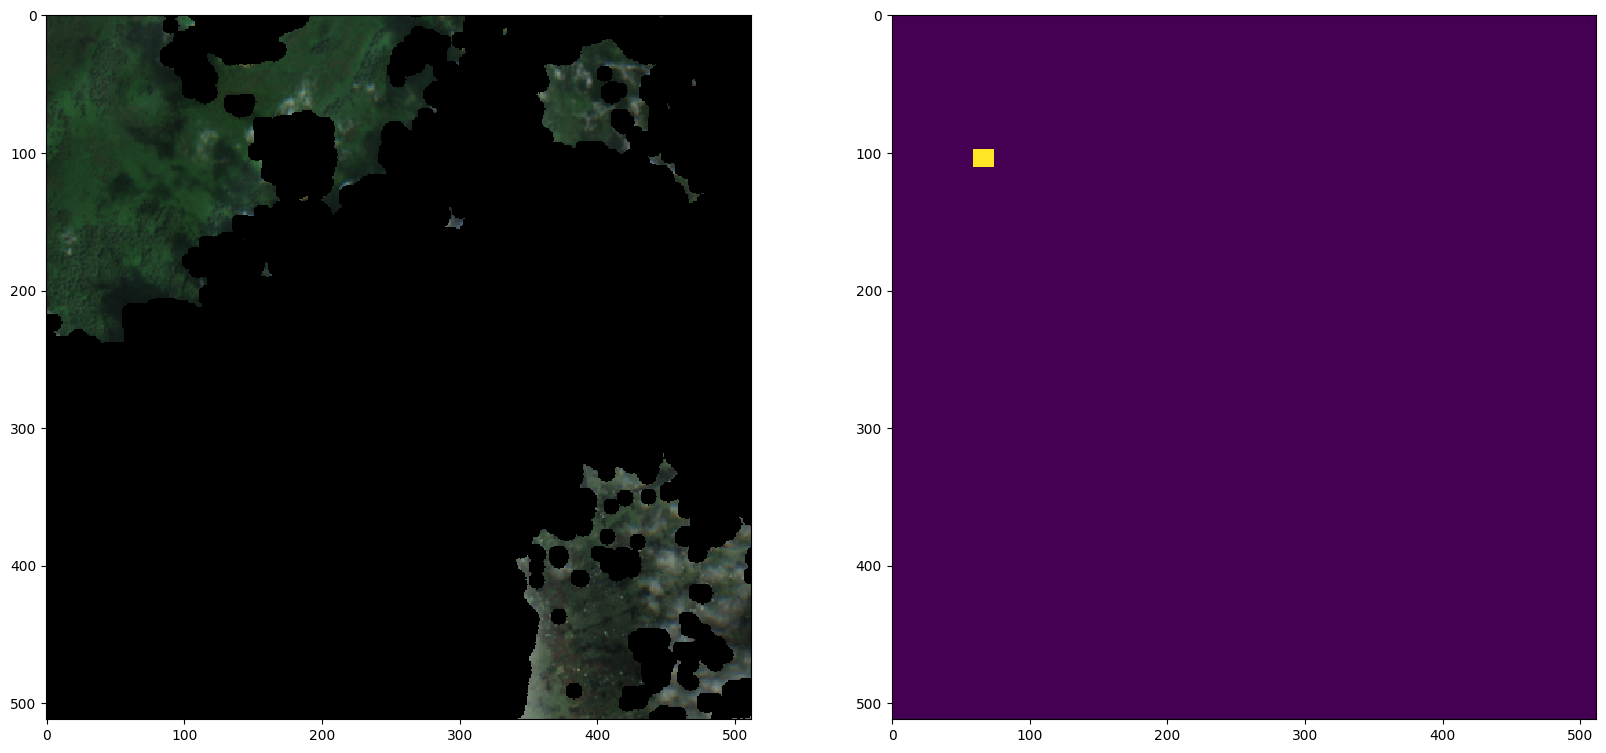

In [26]:
%reload_ext autoreload
%autoreload 2

import common.utilities.visualization as visualization


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

job = '20210101_20210301_south_5_4'

with rasterio.open(f"./data/testingLabelbox/images/{job}.tif") as f:
    data = f.read(masked=True)
    visualization.plot_bands(data, bands=[2, 1, 0], ax=ax1, scale=True, transpose=True)
    
with rasterio.open(f"./data/testingLabelbox/labels/{job}.tif") as f:
    data = f.read(1)
    visualization.plot_bands(data, bands=1, ax=ax2, cmap="viridis")

In [29]:
%%bash

#gdalinfo ./data/testingLabelbox/temp/20200701_20200901_south_labels.tif
#gdalinfo ./data/testingLabelbox/temp/test_image.tif
gdalinfo -stats ./data/testingLabelbox/images/20210101_20210301_south_0_0.tif

Driver: GTiff/GeoTIFF
Files: ./data/testingLabelbox/images/20210101_20210301_south_0_0.tif
Size is 512, 512
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (29.419843151244791,-1.282568144157036)
Pixel Size = (0.000005321225825,-0.000007078426298)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  29.4198432,  -1.2825681) ( 29d25'11.44"E,  1d16'57.25"S)
Lower Left  (  29.4198432,  -1.2861923) ( 29d25'11.44"E,  1d

## Split folders into training / validation

In [11]:
import shutil
import splitfolders


training_dir = "./data/testingTrainingTesting"
splitfolders.ratio(labelbox_dir, output=training_dir, seed=314, ratio=(.8, .2), group_prefix=None)


Copying files: 134 files [00:36,  3.70 files/s]
